In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from matplotlib.lines import Line2D
import numpy as np
import torchvision.utils as vutils
from functools import reduce, partial
import matplotlib.pyplot as plt

In [245]:
def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

def activity_square(vector):
    n = len(vector)
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)

def _plot_grad_flow(named_parameters):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                if p.grad is None:
                    print("%s missing grad" % n)
                else:
                    ave_grads.append(p.grad.abs().mean())
                    max_grads.append(p.grad.abs().max())
        plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
        plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.legend([Line2D([0], [0], color="c", lw=4),
                    Line2D([0], [0], color="b", lw=4),
                    Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [587]:
import rsm_samplers
import rsm
import util
reload(rsm)
reload(rsm_samplers)
reload(util)

from torch.utils.data import DataLoader, BatchSampler

dataset = rsm_samplers.MNISTBufferedDataset("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)

VISUAL = False
DEBUG = False

FLAT = True

predict_memory = None # 'column'

if VISUAL or DEBUG:
    MAX_BATCHES = 5
    EPOCHS = 5
    bs = 1
    plot_interval = 5
else:
    MAX_BATCHES = 30
    EPOCHS = 40
    bs=300
    plot_interval = 5

SEQ = [[2, 4, 0, 7, 8, 1, 6, 1, 8],[2, 7, 4, 9, 5, 9, 3, 1, 0],[5, 7, 3, 4, 1, 3, 1, 6, 4],[1, 3, 7, 5, 2, 5, 5, 3, 4],[2, 9, 1, 9, 2, 8, 3, 2, 7],[1, 2, 6, 4, 8, 3, 5, 0, 3],[3, 8, 0, 5, 6, 4, 1, 3, 9],[4, 7, 5, 3, 7, 6, 7, 2, 4]]
d_in = 28 ** 2
gamma = 0.0  # Inh decay
eps = 0.0  # Memory decay
d_out = tc if predict_memory else d_in
dropout_p = 0.0
pred_gain = 1.0
boost_strength = 1.0
BUFFER = False
fpartition = [0.1, 0.1, 0.8]

if FLAT:
    m = 1000
    n = 1
    k = int(.12 * m)
    k_winner_cells = 1 
    do_inhibition=False
    mult_integration = True
else:
    m=200
    n=6
    k=50
    k_winner_cells=2
    do_inhibition=True
    mult_integration = False    
    
tc = m * n    

sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=bs,
                                            noise_buffer=BUFFER,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)
model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=m, n=n, k=k, eps=eps, gamma=gamma, 
                     k_winner_cells=k_winner_cells, bsz=bs,
                     boost_strat='col_boosting', # 'rsm_inhibition', 
                     pred_gain=pred_gain,
                     dropout_p=dropout_p,
                     x_b_norm=False,
                     mult_integration = mult_integration,
                     boost_strength=boost_strength,
                     mask_shifted_pi=False,
                     fpartition=fpartition,
                     do_inhibition=do_inhibition,
                     debug_log_names=None, #['x_a_batch'], #['pred_output', 'x_b', 'x_b_last'],
                     visual_debug=VISUAL, debug=DEBUG)

criterion = MSELoss()

LR = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [588]:
from util import plot_representation_similarity, plot_activity

x_b = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
phi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
psi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
hidden = (x_b, phi, psi)

# model._register_hooks()

for epoch in range(EPOCHS):
    total_loss = 0.0
    all_xb = []
    condtl_column_dists = {}
    last_out = None
    for i, (data, targets, pred_targets, input_labels) in enumerate(loader):

        hidden = _repackage_hidden(hidden)
        optimizer.zero_grad()
        
        out, hidden = model(data, hidden)
        x_b, phi, psi = hidden
        for _x_b, label, target in zip(x_b, input_labels, pred_targets):
            digit = label.item()
            next_digit = target.item()
            activity = _x_b.detach().view(m, -1)
            key = "%d-%d" % (digit, next_digit)
            if key not in condtl_column_dists:
                condtl_column_dists[key] = []
            condtl_column_dists[key].append(activity)
        
        all_xb.append(x_b)
        loss = None
        if predict_memory:
            # Loss computed between x^A generated at last time step and actual x^B
            if last_out is not None:
                loss = criterion(last_out.squeeze(), x_b.detach())
        else:
            loss = criterion(out, targets)
        
        if loss is not None:
            total_loss += loss.item()
            loss.backward()
        
#             _plot_grad_flow(model.named_parameters())
#             plt.show()
            optimizer.step()
        
        last_out = out
        
        if i >= MAX_BATCHES - 1:
            break
    
    if epoch % plot_interval == 0:
        x_b_mean = torch.cat(all_xb).mean().item()
        batches = MAX_BATCHES * (epoch+1)
        print('mb', batches, 'loss', total_loss / (i+1))
#         plot_representation_similarity(condtl_column_dists, n_labels=4, 
#                                        title=model.boost_strat,
#                                        fontsize=4)
        plt.show()
#         plot_activity(condtl_column_dists, n_labels=4, level='cell')
print('done')

mb 30 loss 0.7971160153547923
mb 180 loss 0.6903698543707529
mb 330 loss 0.6525415082772573
mb 480 loss 0.6264266590277354
mb 630 loss 0.6116718749205271
mb 780 loss 0.6128079295158386
mb 930 loss 0.6074341257413228
mb 1080 loss 0.6047508955001831
done


In [574]:
?torch.Tensor.fill

Object `torch.Tensor.fill` not found.


In [ ]:
# Early train results on PAGI9

# Functionally partitioned
# Flat 1000 x 1, k120, boost 0.4, partition 0.5, - loss@1080 mb: .651-.652
# Flat 1000 x 1, k120, boost 1.0, partition 0.5, - loss@1080 mb: .63 
# Flat 1000 x 1, k120, boost 1.0, partition 0.7, - loss@1080 mb: .648-.651
# Flat 1000 x 1, k120, boost 1.0, partition 0.35, - loss@1080 mb: .61
# Flat 1000 x 1, k120, boost 1.0, partition 0.25, - loss@1080 mb: .604
# Flat 1000 x 1, k120, boost 1.0, partition 0.15, - loss@1080 mb: .601-.605 <<<
# Flat 800 x 1, k12%, boost 1.0, partition 0.15, - loss@1080 mb: .608
# Flat 600 x 1, k12%, boost 1.0, partition 0.25, - loss@1080 mb: .612
# Flat 600 x 1, k12%, boost 1.0, partition 0.15, - loss@1080 mb: .613
# Flat 1000 x 1, k12%, boost 1.0, partition 0.1, - loss@1080 mb: .607-.614
# Flat 1000 x 1, k12%, boost 1.0, partition 0.2, - loss@1080 mb: .607
# Flat 1000 x 1, k9%, boost 1.0, partition 0.2, - loss@1080 mb: .610-.611
# Flat 1000 x 1, k12%, boost 1.0, partition (.15, .15, .7), - loss@1080 mb: .607-.608
# Flat 1000 x 1, k12%, boost 1.0, partition (.1, .1, .8), - loss@1080 mb: .605-.607


# Flat 1000 x 1, k100, boost 2, drop 0 - loss@1080 mb: .677-.680
# Flat 1000 x 1, k100, boost 2, drop 0.5 - loss@1080 mb: .685-.691
# Flat 1000 x 1, k100, boost 3, drop 0 - loss@1080 mb: .679-.680
# Flat 1000 x 1, k200, boost 2, drop 0 - loss@1080 mb: .676-.678
# Flat 1000 x 1, k250, boost 2, drop 0 - loss@1080 mb: .668-.674 
# Flat 1000 x 1, k300, boost 2, drop 0 - loss@1080 mb: .676-.678
# Flat 1000 x 1, k250, boost 1, drop 0 - loss@1080 mb: .671-.673
# Flat 1000 x 1, k250, boost 1.5, drop 0 - loss@1080 mb: .670-.674 
# Flat 1000 x 1, k250, boost 3, drop 0 - loss@1080 mb: .679-.680
# Flat 1000 x 1, k275, boost 2, drop 0 - loss@1080 mb: .675-.679
# Flat 1000 x 1, k275, boost 1, drop 0 - loss@1080 mb: .671-.671
# Flat 1000 x 1, k275, boost 1.25, drop 0 - loss@1080 mb: .669-.671
# Flat 1000 x 1, k275, boost 0.7, drop 0 - loss@1080 mb: .667-.668 <<<
# Flat 1000 x 1, k275, boost 0.5, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k275, boost 0.4, drop 0 - loss@1080 mb: .670
# Flat 1000 x 1, k275, boost 0.3, drop 0 - loss@1080 mb: .670
# Flat 1000 x 1, k300, boost 0.7, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k325, boost 0.7, drop 0 - loss@1080 mb: .675
# Flat 1000 x 1, k300, boost 0.5, drop 0 - loss@1080 mb: .674-.677
# Flat 1000 x 1, k250, boost 0.7, drop 0 - loss@1080 mb: .672
# Flat 1000 x 1, k275, boost 1.0, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k300, boost 1.0, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k100, boost 0.5, drop 0 - loss@1080 mb: .680
# Flat 1000 x 1, k200, boost 0.5, drop 0 - loss@1080 mb: .670-.672
# Flat 1000 x 1, k200, boost 1.0, drop 0 - loss@1080 mb: .674


tensor(1) tensor(0)


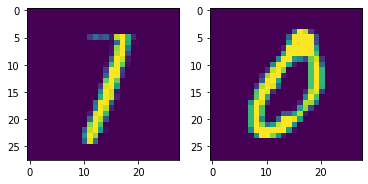

tensor(0) tensor(4)


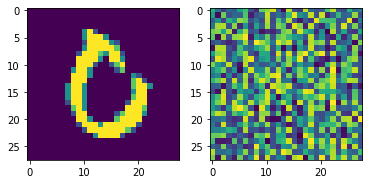

tensor(4) tensor(3)


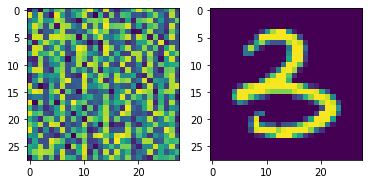

tensor(3) tensor(8)


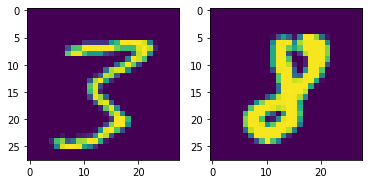

tensor(8) tensor(0)


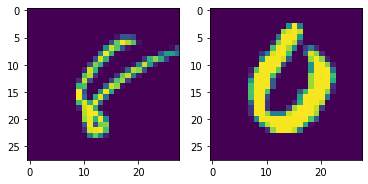

tensor(0) tensor(5)


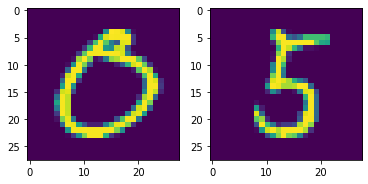

tensor(5) tensor(6)


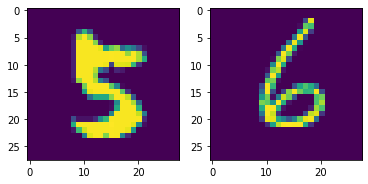

tensor(6) tensor(4)


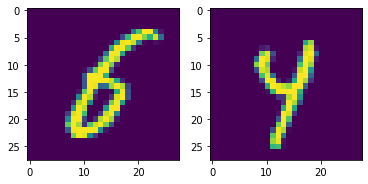

tensor(4) tensor(1)


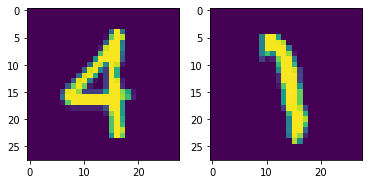

tensor(1) tensor(3)


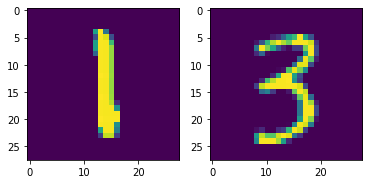

tensor(3) tensor(9)


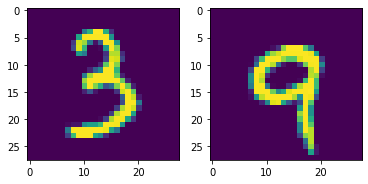

In [497]:
sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=1,
                                            noise_buffer=True,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)


for i in range(11):
    inp_img, tgt_img, tgt_label, inp_label = next(iter(loader))
    print(inp_label[0], tgt_label[0])
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(inp_img[0].view(28, 28))
    axs[1].imshow(tgt_img[0].view(28, 28))    
    plt.show()

compare_correct torch.Size([2, 300])
compare_with torch.Size([20, 1, 28, 28])


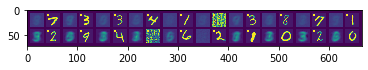

In [517]:
def _image_grid(image_batch, n_seqs=10, compare_with=None, compare_correct=None, limit_seqlen=50):
    '''
    image_batch: n_batches x batch_size x image_dim
    '''
    side = 28
    image_batch = image_batch[:, :n_seqs].reshape(-1, 1, side, side)
    if compare_with is not None:
        # Interleave comparison images with image_batch
        compare_with = compare_with[:, :n_seqs].reshape(-1, 1, side, side)
        max_val = compare_with.max()
        if compare_correct is not None:
            # Add 'incorrect label' to each image (masked by inverse of compare_correct)
            # as 2x2 square 'dot' in upper left corner of falsely predicted targets
            dot_size = 4
            gap = 2
            print('compare_correct', compare_correct.size())
            print('compare_with', compare_with.size())
            incorrect = ~compare_correct[:, :n_seqs].flatten()
            compare_with[incorrect, :, gap:gap + dot_size, gap:gap + dot_size] = max_val
        batch = torch.empty((image_batch.shape[0] + compare_with.shape[0], image_batch.shape[1], side, side))
        batch[::2, :, :] = image_batch
        batch[1::2, :, :] = compare_with
    else:
        batch = image_batch
    # make_grid returns 3 channels -- mean since grayscale
    grid = vutils.make_grid(batch[:2*limit_seqlen*n_seqs], normalize=True, nrow=n_seqs * 2, padding=5).mean(dim=0)  
    return grid

sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=bs,
                                            noise_buffer=True,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

x_b = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
phi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
psi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
hidden = (x_b, phi, psi)

loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)
all_x_a_next = all_targets = all_correct_arrs = all_pred_targets = all_class_predictions = None
for i in range(2):
    inputs, targets, pred_targets, input_labels = next(iter(loader))
    
    x_a_next, hidden = model(inputs, hidden)
    
    class_predictions = torch.zeros(bs).long()
    correct_arr = class_predictions == pred_targets
    
    x_a_next.unsqueeze_(0)
    targets.unsqueeze_(0)
    correct_arr.unsqueeze_(0)
    all_x_a_next = x_a_next if all_x_a_next is None else torch.cat((all_x_a_next, x_a_next))
    all_targets = targets if all_targets is None else torch.cat((all_targets, targets))
    all_correct_arrs = correct_arr if all_correct_arrs is None else torch.cat((all_correct_arrs, correct_arr))
    all_pred_targets = pred_targets if all_pred_targets is None else torch.cat((all_pred_targets, pred_targets))                
    all_class_predictions = class_predictions if all_class_predictions is None else torch.cat((all_class_predictions, class_predictions))                


grid = _image_grid(all_x_a_next.detach(), 
            compare_with=all_targets, 
            compare_correct=all_correct_arrs).cpu()
plt.imshow(grid)

In [524]:
from util import count_parameters

def param_count(model):
    print(str(model))
    for n, p in model.named_parameters():
        if p.requires_grad:
            els = p.numel()
            print(n, els)

model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=200, n=6, k=k, eps=eps, gamma=gamma, 
                     k_winner_cells=k_winner_cells, bsz=bs)

param_count(model)

model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=1000, n=1, k=k, eps=eps, gamma=gamma, 
                     k_winner_cells=k_winner_cells, bsz=bs)

param_count(model)


RSMLayer(
  (dropout): Dropout(p=0.0)
  (kwinners_col): KWinners(n=200, percent_on=0.6, boost_strength=1.0, duty_cycle_period=5000)
  (linear_a): Linear(in_features=784, out_features=200, bias=True)
  (linear_b): Linear(in_features=1200, out_features=1200, bias=True)
  (linear_d): Linear(in_features=200, out_features=784, bias=True)
)
linear_a.weight 156800
linear_a.bias 200
linear_b.weight 1440000
linear_b.bias 1200
linear_d.weight 156800
linear_d.bias 784
RSMLayer(
  (dropout): Dropout(p=0.0)
  (kwinners_col): KWinners(n=1000, percent_on=0.12, boost_strength=1.0, duty_cycle_period=5000)
  (linear_a): Linear(in_features=784, out_features=1000, bias=True)
  (linear_b): Linear(in_features=1000, out_features=1000, bias=True)
  (linear_d): Linear(in_features=1000, out_features=784, bias=True)
)
linear_a.weight 784000
linear_a.bias 1000
linear_b.weight 1000000
linear_b.bias 1000
linear_d.weight 784000
linear_d.bias 784
